### Add path to structure learning library (skip if installed via pip)

In [1]:
import sys
sys.path.append('../src')

### Import relevant classes, set random seed

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from structure_learning.data import SyntheticDataset, Data
from structure_learning.data_structures import DAG
from structure_learning.scores import BGeScore
from structure_learning.distributions import Distribution
from structure_learning.experiments import Experiment
from structure_learning.evaluation.metrics import RHat, MSE
# for reproducibility
np.random.seed(100)

### 1. Setup experiment by defining an instance of Experiment class

In [3]:
# setup synthetic data
num_nodes = 5
node_labels = [chr(ord('a') + i) for i in range(num_nodes)]
num_obs = 200
degree = 2

synthetic_data = SyntheticDataset(num_nodes=num_nodes, num_obs=num_obs, node_labels=node_labels, degree=degree)
synthetic_data.data.values.to_csv('test.csv')

00010 00100 10000 00000 01010


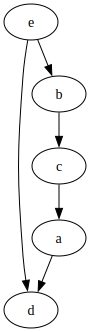

In [4]:
# visualise ground truth DAG
synthetic_data.graph.plot()

In [5]:
true_dist = Distribution.compute_distribution(data=synthetic_data.data, score=BGeScore, graph_type='dag')

np.save('true_distribution.npy', true_dist)

In [6]:

np.save('cpdag.npy', synthetic_data.graph.to_cpdag())

#### configurations of samplers to run

In [7]:
samplers = [
    {
        "sampler_type": "StructureMCMC",
        "n_chains": 2,
        "seeds": [1990, 1981],
        "config": {
            "max_iter": 100000,
            "score_object": "bge",
            "pc_init": False,
            "result_type": "opad",
            "graph_type": "dag",
        }
    },
    {
        "sampler_type": "StructureMCMC",
        "n_chains": 1,
        "seeds": [1990],
        "config": {
            "max_iter": 100000,
            "score_object": "bge",
            "pc_init": False,
            "result_type": "opad+",
            "graph_type": "dag",
        }
    },
    {
        "sampler_type": "PartitionMCMC",
        "n_chains": 2,
        "seeds": [1990, 1981],
        "config": {
            "max_iter": 100000,
            "score_object": "bge",
            "result_type": "opad",
            "graph_type": "dag",
            "searchspace": "FULL"
        }
    }
]

#### run the experiment

In [8]:
exp = Experiment(experiment_name='test', data=synthetic_data.data, samplers=samplers, ground_truth='true_distribution.npy', metrics=['mae', 'mse', 'rhat', 'kld', 'jsd'], n_threads=8, seed=42, snapshot_interval=10000)
res = exp.run()

Adding rejected particles
Adding rejected particles
Adding rejected particles
Adding rejected particles
Adding rejected particles
Adding rejected particles
Adding rejected particles
Adding rejected particles
Adding rejected particles
Adding rejected particles
Adding rejected particles


#### evaluate

<Figure size 640x480 with 0 Axes>

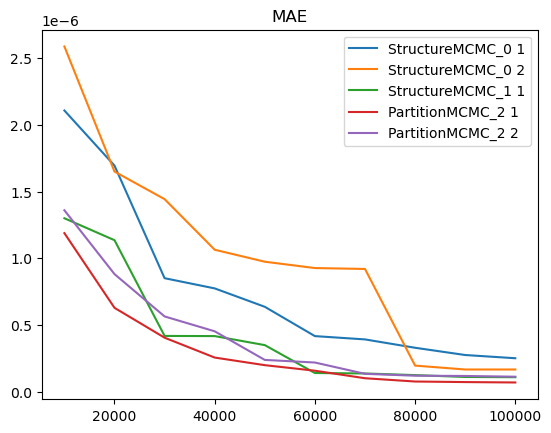

<Figure size 640x480 with 0 Axes>

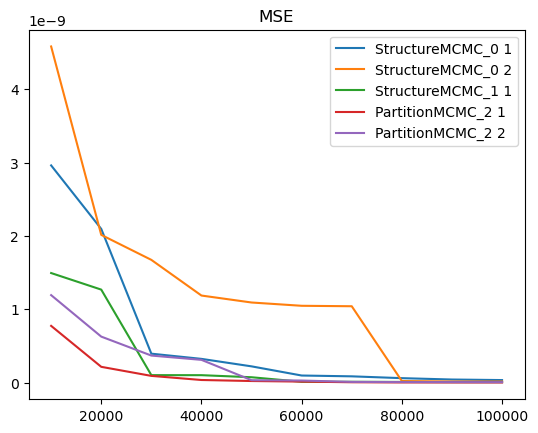

/Users/165421/Documents/code/structure_learning/examples/../src/structure_learning/experiments/experiment.py:77: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


<Figure size 640x480 with 0 Axes>

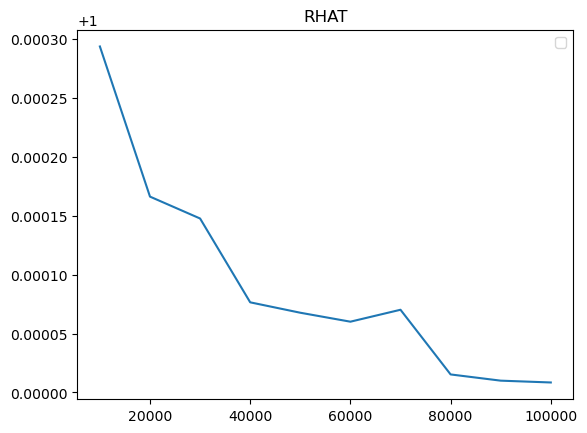

<Figure size 640x480 with 0 Axes>

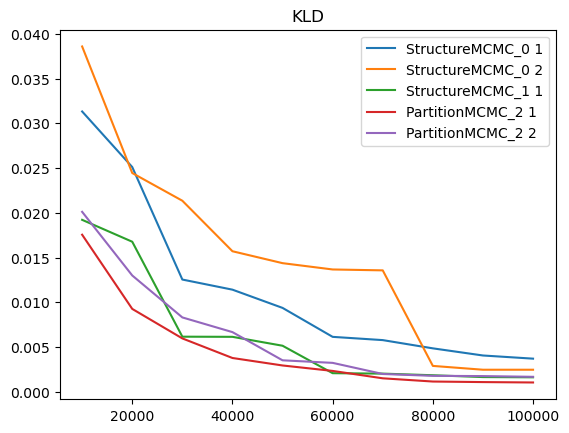

<Figure size 640x480 with 0 Axes>

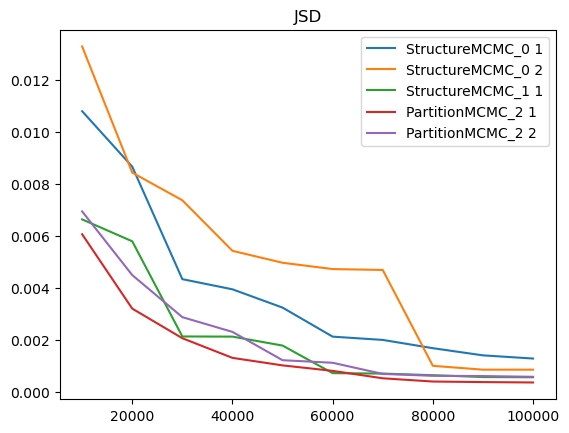

{10000: {'mae': [2.1062757222235742e-06,
   2.5852444139178698e-06,
   1.2998722925535516e-06,
   1.1884230934972612e-06,
   1.3597468597767262e-06],
  'mse': [2.9626075872247063e-09,
   4.58452790081289e-09,
   1.494878805120122e-09,
   7.745391683684433e-10,
   1.1936766886180311e-09],
  'rhat': [1.000293814996264],
  'kld': [0.031321570211354496,
   0.038583323222122,
   0.019213541376702465,
   0.017551465652793398,
   0.02010740149244081],
  'jsd': [0.010807531653371408,
   0.013299617097370119,
   0.006640907196948379,
   0.00606781336507185,
   0.006948968599232086]},
 20000: {'mae': [1.6938586374251421e-06,
   1.6493851540134962e-06,
   1.1357594067215036e-06,
   6.297038436737721e-07,
   8.820235368956372e-07],
  'mse': [2.0966214103548646e-09,
   2.0153847442231575e-09,
   1.269033150744541e-09,
   2.1605628963806324e-10,
   6.281087535464136e-10],
  'rhat': [1.0001663168821575],
  'kld': [0.025110831836529707,
   0.02444340659946735,
   0.016767278066007973,
   0.00926126565

In [9]:
sampler_types = [f'{sampler['sampler_type']}_{idx} {i+1}' for idx, sampler in enumerate(samplers) for i in range(sampler.get('n_chains', 1))]
exp.evaluate(plot=True, plot_labels=sampler_types)

#### plot distributions

/Users/165421/Documents/code/structure_learning/examples/../src/structure_learning/distributions/distribution.py:211: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(a_melt['index'], rotation=90)


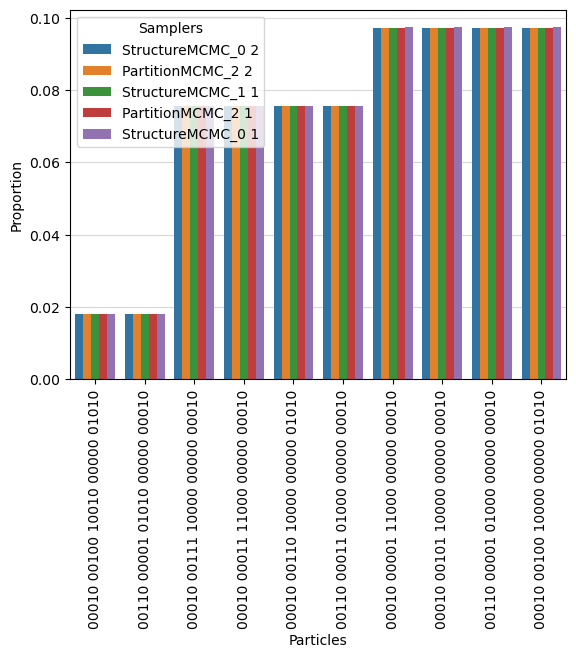

In [10]:
_ = Distribution.plot_multiple([r[0][-1][0] for r in res], prop='p', labels=sampler_types, limit=10)

In [11]:
### create yaml file for the experiment
yaml_content = exp.to_yaml('test.yaml')

### run experiment from yaml configuration

In [12]:
import pandas as pd

exp2 = Experiment.from_yaml('test.yaml', data=synthetic_data.data, ground_truth='true_distribution.npy')
res2 = exp2.run()
exp2.evaluate()

{'experiment_name': 'test', 'ground_truth': 'true_distribution.npy', 'metrics': ['mae', 'mse', 'rhat', 'kld', 'jsd'], 'n_threads': 8, 'samplers': [{'config': {'graph_type': 'dag', 'initial_state': None, 'max_iter': 100000, 'pc_ci_test': 'pearsonr', 'pc_init': False, 'pc_significance_level': 0.01, 'proposal_object': 'graph', 'result_type': 'opad', 'score_object': 'BGeScore', 'seed': 1990, 'sparse': True}, 'sampler_type': 'StructureMCMC'}, {'config': {'graph_type': 'dag', 'initial_state': None, 'max_iter': 100000, 'pc_ci_test': 'pearsonr', 'pc_init': False, 'pc_significance_level': 0.01, 'proposal_object': 'graph', 'result_type': 'opad', 'score_object': 'BGeScore', 'seed': 1981, 'sparse': True}, 'sampler_type': 'StructureMCMC'}, {'config': {'graph_type': 'dag', 'initial_state': None, 'max_iter': 100000, 'pc_ci_test': 'pearsonr', 'pc_init': False, 'pc_significance_level': 0.01, 'proposal_object': 'graph', 'result_type': 'opad+', 'score_object': 'BGeScore', 'seed': 1990, 'sparse': True}, '

{10000: {'mae': [2.1062757222235742e-06,
   2.5852444139178698e-06,
   1.2998722925535516e-06,
   1.5781223230914232e-06,
   1.3831865894329616e-06],
  'mse': [2.9626075872247063e-09,
   4.58452790081289e-09,
   1.494878805120122e-09,
   1.9195297279889934e-09,
   1.0220746191418097e-09],
  'rhat': [1.0002577586176713],
  'kld': [0.031321570211354496,
   0.038583323222122,
   0.019213541376702465,
   0.023374809377098692,
   0.020457582413217077],
  'jsd': [0.010807531653371408,
   0.013299617097370119,
   0.006640907196948379,
   0.008074482084081222,
   0.0070696403844879695]},
 20000: {'mae': [1.6938586374251421e-06,
   1.6493851540134962e-06,
   1.1357594067215036e-06,
   1.168691614961393e-06,
   7.103039050794991e-07],
  'mse': [2.0966214103548646e-09,
   2.0153847442231575e-09,
   1.269033150744541e-09,
   1.3009452878420074e-09,
   2.843042554328476e-10],
  'rhat': [1.0001355826231821],
  'kld': [0.025110831836529707,
   0.02444340659946735,
   0.016767278066007973,
   0.017257